## POS tagging 

###  Using the TreeBank universal tag set corpus, build a Viterbi PoS tagger, 
##### Later, improve the performance to solve for the unknown words 

### Data Preparation

In [1]:
#Importing libraries
import nltk, re
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import random
from nltk.tokenize import word_tokenize

In [2]:
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\nsrip\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [3]:
# reading the Treebank tagged sentences
df = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [4]:
# first few tagged sentences
print(df[:5])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [5]:
# Splitting into train and test
from sklearn.model_selection import train_test_split

random.seed(59)
train_set, test_set = train_test_split(df,test_size=0.05)

print(len(train_set))
print(len(test_set))
print(train_set[:5])

3718
196
[[('Some', 'DET'), ('dealers', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('the', 'DET'), ('Treasury', 'NOUN'), ("'s", 'PRT'), ('intent', 'NOUN'), ('is', 'VERB'), ('*', 'X'), ('to', 'PRT'), ('help', 'VERB'), ('government', 'NOUN'), ('bond', 'NOUN'), ('dealers', 'NOUN'), ('gauge', 'VERB'), ('investor', 'NOUN'), ('demand', 'NOUN'), ('for', 'ADP'), ('the', 'DET'), ('securities', 'NOUN'), (',', '.'), ('*', 'X'), ('given', 'VERB'), ('uncertainties', 'NOUN'), ('about', 'ADP'), ('when', 'ADV'), ('the', 'DET'), ('auction', 'NOUN'), ('will', 'VERB'), ('occur', 'VERB'), ('*T*-1', 'X'), ('.', '.')], [('Nissan', 'NOUN'), ('scheduled', 'VERB'), ('a', 'DET'), ('seven-yen', 'ADJ'), ('interim', 'ADJ'), ('dividend', 'NOUN'), ('payment', 'NOUN'), (',', '.'), ('unchanged', 'ADJ'), ('.', '.')], [('Mr.', 'NOUN'), ('Otero', 'NOUN'), (',', '.'), ('who', 'PRON'), ('*T*-249', 'X'), ('apparently', 'ADV'), ('has', 'VERB'), ('an', 'DET'), ('unpublished', 'ADJ'), ('number', 'NOUN'), (',', '.'), ('also', 'ADV'

In [6]:
# Getting list of tagged words
train_tagged = [tup for sent in train_set for tup in sent]
len(train_tagged)

95524

In [7]:
# tokens 
tokens = [pair[0] for pair in train_tagged]
tokens[:10]

['Some', 'dealers', 'said', '0', 'the', 'Treasury', "'s", 'intent', 'is', '*']

In [8]:
# vocabulary
V = set(tokens)
print(len(V))

12079


In [9]:
# number of tags
T = set([pair[1] for pair in train_tagged])
len(T)

12

In [10]:
print(T)

{'NOUN', 'ADV', 'ADJ', 'NUM', 'CONJ', 'PRON', 'PRT', 'X', '.', 'ADP', 'VERB', 'DET'}


##  POS Tagging Algorithm - HMM
### Emission Probabilities

In [11]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [12]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

### Transition Probabilities

In [13]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [14]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [15]:
tags_matrix

array([[2.64446795e-01, 1.67769287e-02, 1.19521916e-02, 9.02810786e-03,
        4.29474749e-02, 4.75163572e-03, 4.40074578e-02, 2.95332428e-02,
        2.40432769e-01, 1.75298810e-01, 1.47483468e-01, 1.33411307e-02],
       [3.24825980e-02, 8.05435851e-02, 1.29598945e-01, 3.24825980e-02,
        6.62910193e-03, 1.55783892e-02, 1.35896588e-02, 2.25389451e-02,
        1.35565132e-01, 1.18660919e-01, 3.43718916e-01, 6.86112046e-02],
       [6.97728038e-01, 4.28054016e-03, 6.68422803e-02, 2.12380644e-02,
        1.71221606e-02, 4.93908476e-04, 1.08659863e-02, 2.09087916e-02,
        6.56898245e-02, 7.85314441e-02, 1.16891665e-02, 4.60981252e-03],
       [3.50404322e-01, 2.99490872e-03, 3.32434848e-02, 1.86283320e-01,
        1.40760709e-02, 1.49745436e-03, 2.81521417e-02, 2.09344119e-01,
        1.18298888e-01, 3.56394127e-02, 1.67714879e-02, 3.29439947e-03],
       [3.51413995e-01, 5.51692173e-02, 1.18683353e-01, 4.17246185e-02,
        4.63606848e-04, 5.84144630e-02, 4.63606883e-03, 7.88

In [16]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [17]:
tags_df

,NOUN,ADV,ADJ,NUM,CONJ,PRON,PRT,X,.,ADP,VERB,DET
NOUN,0.264447,0.016777,0.011952,0.009028,0.042947,0.004752,0.044007,0.029533,0.240433,0.175299,0.147483,0.013341
ADV,0.032483,0.080544,0.129599,0.032483,0.006629,0.015578,0.013590,0.022539,0.135565,0.118661,0.343719,0.068611
ADJ,0.697728,0.004281,0.066842,0.021238,0.017122,0.000494,0.010866,0.020909,0.065690,0.078531,0.011689,0.004610
NUM,0.350404,0.002995,0.033243,0.186283,0.014076,0.001497,0.028152,0.209344,0.118299,0.035639,0.016771,0.003294
CONJ,0.351414,0.055169,0.118683,0.041725,0.000464,0.058414,0.004636,0.007881,0.035234,0.051460,0.155772,0.119147
PRON,0.207294,0.031862,0.071017,0.007678,0.004990,0.008061,0.012668,0.092898,0.041459,0.021881,0.491747,0.008445
PRT,0.248851,0.009849,0.084373,0.056796,0.002298,0.017072,0.001313,0.013789,0.043992,0.020026,0.400854,0.100788
X,0.063215,0.026048,0.016360,0.002859,0.010324,0.056544,0.182656,0.075445,0.162643,0.144695,0.204892,0.054320
.,0.220607,0.052235,0.044965,0.079429,0.057979,0.066505,0.002513,0.027374,0.093610,0.091815,0.089302,0.173577
ADP,0.323009,0.013718,0.106205,0.062051,0.000857,0.068481,0.001393,0.034187,0.040296,0.016933,0.008681,0.324188


In [18]:
tags_df.loc['.', :]

NOUN    0.220607
ADV     0.052235
ADJ     0.044965
NUM     0.079429
CONJ    0.057979
PRON    0.066505
PRT     0.002513
X       0.027374
.       0.093610
ADP     0.091815
VERB    0.089302
DET     0.173577
Name: ., dtype: float32

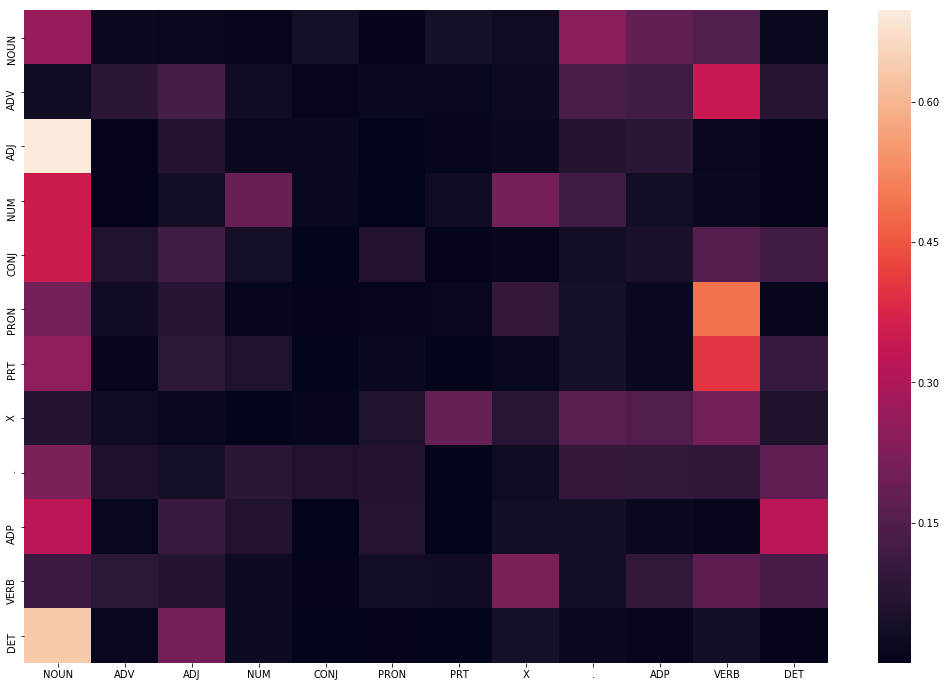

In [19]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()


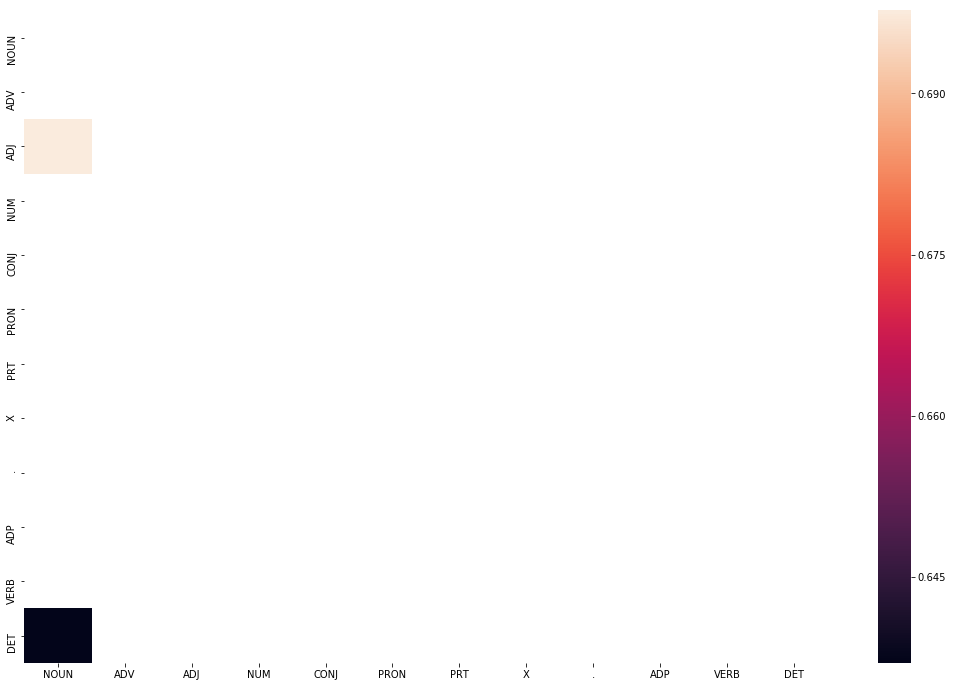

In [20]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

In [21]:
len(train_tagged)

95524

### Build the vanilla Viterbi based POS tagger

In [22]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [23]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged = [tup[0] for sent in test_run for tup in sent]
test_run

[[('Fees', 'NOUN'), ('2', 'NUM'), ('1\\/4', 'NUM'), ('.', '.')],
 [('Rep.', 'NOUN'),
  ('Jerry', 'NOUN'),
  ('Lewis', 'NOUN'),
  (',', '.'),
  ('a', 'DET'),
  ('conservative', 'ADJ'),
  ('Californian', 'NOUN'),
  (',', '.'),
  ('added', 'VERB'),
  ('a', 'DET'),
  ('provision', 'NOUN'),
  ('of', 'ADP'),
  ('his', 'PRON'),
  ('own', 'ADJ'),
  ('intended', 'VERB'),
  ('*', 'X'),
  ('to', 'PRT'),
  ('assist', 'VERB'),
  ('Bolivia', 'NOUN'),
  (',', '.'),
  ('and', 'CONJ'),
  ('the', 'DET'),
  ('Senate', 'NOUN'),
  ('then', 'ADV'),
  ('broadened', 'VERB'),
  ('the', 'DET'),
  ('list', 'NOUN'),
  ('further', 'ADV'),
  ('by', 'ADP'),
  ('*-1', 'X'),
  ('including', 'VERB'),
  ('all', 'DET'),
  ('countries', 'NOUN'),
  ('in', 'ADP'),
  ('the', 'DET'),
  ('U.S.', 'NOUN'),
  ('Caribbean', 'NOUN'),
  ('Basin', 'NOUN'),
  ('initiate', 'NOUN'),
  ('as', 'ADV'),
  ('well', 'ADV'),
  ('as', 'ADP'),
  ('the', 'DET'),
  ('Philippines', 'NOUN'),
  ('-', '.'),
  ('*-1', 'X'),
  ('backed', 'VERB'),
  ('*'

In [24]:
# tagging the test sentences
tagged_seq = Viterbi(test_tagged)

In [25]:
print(tagged_seq)
#print(test_run_base)

[('Fees', 'NOUN'), ('2', 'NUM'), ('1\\/4', 'NUM'), ('.', '.'), ('Rep.', 'NOUN'), ('Jerry', 'NOUN'), ('Lewis', 'NOUN'), (',', '.'), ('a', 'DET'), ('conservative', 'ADJ'), ('Californian', 'NOUN'), (',', '.'), ('added', 'VERB'), ('a', 'DET'), ('provision', 'NOUN'), ('of', 'ADP'), ('his', 'PRON'), ('own', 'ADJ'), ('intended', 'VERB'), ('*', 'X'), ('to', 'PRT'), ('assist', 'VERB'), ('Bolivia', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('the', 'DET'), ('Senate', 'NOUN'), ('then', 'ADV'), ('broadened', 'NOUN'), ('the', 'DET'), ('list', 'NOUN'), ('further', 'ADV'), ('by', 'ADP'), ('*-1', 'X'), ('including', 'VERB'), ('all', 'DET'), ('countries', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('U.S.', 'NOUN'), ('Caribbean', 'NOUN'), ('Basin', 'NOUN'), ('initiate', 'NOUN'), ('as', 'ADP'), ('well', 'ADV'), ('as', 'ADP'), ('the', 'DET'), ('Philippines', 'NOUN'), ('-', '.'), ('*-1', 'X'), ('backed', 'VERB'), ('*', 'X'), ('by', 'ADP'), ('the', 'DET'), ('powerful', 'ADJ'), ('Hawaii', 'NOUN'), ('Democrat', 'NOUN

In [26]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]
accuracy_vanilla_viterbi = len(check)/len(tagged_seq)
accuracy_vanilla_viterbi

0.9098360655737705

In [27]:
incorrect_tagged_vanilla_viterbi = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_vanilla_viterbi

[[('then', 'ADV'), (('broadened', 'NOUN'), ('broadened', 'VERB'))],
 [('initiate', 'NOUN'), (('as', 'ADP'), ('as', 'ADV'))],
 [('shipped', 'VERB'), (('*-97', 'NOUN'), ('*-97', 'X'))],
 [('in', 'ADP'), (('six-bottle', 'NOUN'), ('six-bottle', 'ADJ'))],
 [('at', 'ADP'), (('that', 'DET'), ('that', 'ADP'))],
 [('spread', 'VERB'), (('*-98', 'NOUN'), ('*-98', 'X'))],
 [(',', '.'), (('*-98', 'NOUN'), ('*-98', 'X'))],
 [('.', '.'), (('Average', 'NOUN'), ('Average', 'ADJ'))],
 [(':', '.'), (('83,206', 'NOUN'), ('83,206', 'NUM'))],
 [('Cabernet', 'NOUN'), (('weighed', 'NOUN'), ('weighed', 'VERB'))],
 [('weighed', 'VERB'), (('in', 'ADP'), ('in', 'PRT'))]]

In [28]:
## Testing
sentence_test = 'Google and Twitter made a deal in 2015 that gave Google access to Twitter\'s firehose.'
words = word_tokenize(sentence_test)


tagged_seq = Viterbi(words)

In [29]:
print(tagged_seq)

[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NOUN'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')]


### Solve the problem of unknown words

1. Use lexical techniqies on the same data to see if we get a better accuracy <br>
2. Use these to tag unknown words, and watch out for the result



In [30]:
# specify patterns for tagging
# example from the NLTK book
patterns = [(r'.*ing$', 'VBG'), (r'.*ed$', 'VBD'),  (r'.*es$', 'VBZ'), (r'.*ould$', 'MD'),          
            (r'.*\'s$', 'NN$'), (r'.*s$', 'NNS'), (r'^-?[0-9]+(.[0-9]+)?$', 'CD'), (r'.*', 'NN')]

# gerund, past tense, 3rd singular present, modals, possessive nounds, plural nouns, cardinal numbers, nounds in order

In [31]:
# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

# lexicon backed up by the rule-based tagger
lexicon_tagger = nltk.UnigramTagger(train_set, backoff=rule_based_tagger)

accuracy_lexicon_tagger = lexicon_tagger.evaluate(test_set)
print(accuracy_lexicon_tagger)

0.9029503105590062


Trigram tagger

In [32]:
# Bigram and Trigram tagger
bigram_tagger = nltk.BigramTagger(train_set,backoff=lexicon_tagger)
bigram_tagger.evaluate(test_set)
accuracy_bigram_tagger = bigram_tagger.evaluate(test_set)
print(accuracy_bigram_tagger)

0.9070263975155279


In [33]:
trigram_regex = nltk.TrigramTagger(train_set, backoff=bigram_tagger)
trigram_regex.evaluate(test_set)

accuracy_trigram_regex = trigram_regex.evaluate(test_set)
print(accuracy_trigram_regex)

0.9083850931677019


Getting marginally better, but not by much. <br>
Next lets see if we can use this for the unknown words 


Now to build this into viterbi, need to change the regex patterns to fit for the tags in our data (NOUN instead of NNS etc)  

In [34]:
print(T)

{'NOUN', 'ADV', 'ADJ', 'NUM', 'CONJ', 'PRON', 'PRT', 'X', '.', 'ADP', 'VERB', 'DET'}


In [35]:
def trigram_regex(word,train_set = train_set):
    patterns1 = [(r'.*ing$', 'VERB'), (r'.*ed$', 'VERB'), (r'.*es$', 'VERB'), (r'.*ould$', 'X'),        
    (r'.*\'s$', 'NOUN'), (r'.*s$', 'NOUN'), (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), (r'.*', 'NOUN')]
# gerund, past tense, 3rd singular present, modals, possessive nounds, plural nouns, cardinal numbers, nounds in order    
    regex_based_tagger = nltk.RegexpTagger(patterns1)

    # trigram backed up by the regex tagger
    trigram_regex_tagger = nltk.TrigramTagger(train_set, backoff=regex_based_tagger)
    return trigram_regex_tagger.tag_sents([[(word)]])

In [36]:
# viterbi with handling for unknown words from regex tagger

def Viterbi_modified(words, train_bag = train_tagged):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        # unknown words from trigram taggr
        if word not in tokens:
            unk_word_tag=trigram_regex(word)
            for sent in unk_word_tag:
                for tup in sent:
                    state.append(tup[1])
        # rest remains same            
        else:            
            p = [] 
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
            
    return list(zip(words, state))

In [37]:
tagged_seq = Viterbi_modified(test_tagged)

#### Evaluating tagging accuracy

In [38]:

test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged = [tup[0] for sent in test_run for tup in sent]
test_tagged

['Fees',
 '2',
 '1\\/4',
 '.',
 'Rep.',
 'Jerry',
 'Lewis',
 ',',
 'a',
 'conservative',
 'Californian',
 ',',
 'added',
 'a',
 'provision',
 'of',
 'his',
 'own',
 'intended',
 '*',
 'to',
 'assist',
 'Bolivia',
 ',',
 'and',
 'the',
 'Senate',
 'then',
 'broadened',
 'the',
 'list',
 'further',
 'by',
 '*-1',
 'including',
 'all',
 'countries',
 'in',
 'the',
 'U.S.',
 'Caribbean',
 'Basin',
 'initiate',
 'as',
 'well',
 'as',
 'the',
 'Philippines',
 '-',
 '*-1',
 'backed',
 '*',
 'by',
 'the',
 'powerful',
 'Hawaii',
 'Democrat',
 'Sen.',
 'Daniel',
 'Inouye',
 '.',
 'The',
 'wine',
 'was',
 'shipped',
 '*-97',
 'in',
 'six-bottle',
 'cases',
 'instead',
 'of',
 'the',
 'usual',
 '12',
 ',',
 'but',
 'even',
 'at',
 'that',
 'it',
 'was',
 'spread',
 '*-98',
 'thin',
 ',',
 '*-98',
 'going',
 'to',
 '62',
 'retailers',
 'in',
 '28',
 'states',
 '.',
 'Average',
 'daily',
 'trading',
 'volume',
 ':',
 '83,206',
 'shares',
 'Diamond',
 'Creek',
 '1985',
 'Lake',
 'Vineyard',
 'Cabern

In [39]:
# tagging the test sentences
tagged_seq_modified = Viterbi_modified(test_tagged)

In [40]:
print(tagged_seq_modified)

[('Fees', 'NOUN'), ('2', 'NUM'), ('1\\/4', 'NUM'), ('.', '.'), ('Rep.', 'NOUN'), ('Jerry', 'NOUN'), ('Lewis', 'NOUN'), (',', '.'), ('a', 'DET'), ('conservative', 'ADJ'), ('Californian', 'NOUN'), (',', '.'), ('added', 'VERB'), ('a', 'DET'), ('provision', 'NOUN'), ('of', 'ADP'), ('his', 'PRON'), ('own', 'ADJ'), ('intended', 'VERB'), ('*', 'X'), ('to', 'PRT'), ('assist', 'VERB'), ('Bolivia', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('the', 'DET'), ('Senate', 'NOUN'), ('then', 'ADV'), ('broadened', 'VERB'), ('the', 'DET'), ('list', 'NOUN'), ('further', 'ADV'), ('by', 'ADP'), ('*-1', 'X'), ('including', 'VERB'), ('all', 'DET'), ('countries', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('U.S.', 'NOUN'), ('Caribbean', 'NOUN'), ('Basin', 'NOUN'), ('initiate', 'NOUN'), ('as', 'ADP'), ('well', 'ADV'), ('as', 'ADP'), ('the', 'DET'), ('Philippines', 'NOUN'), ('-', '.'), ('*-1', 'X'), ('backed', 'VERB'), ('*', 'X'), ('by', 'ADP'), ('the', 'DET'), ('powerful', 'ADJ'), ('Hawaii', 'NOUN'), ('Democrat', 'NOUN

In [41]:
# accuracy
check1 = [i for i, j in zip(tagged_seq_modified, test_run_base) if i == j]
accuracy_viterbi_modified = len(check1)/len(tagged_seq_modified)
accuracy_viterbi_modified

0.9344262295081968

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [42]:
print(accuracy_vanilla_viterbi)

0.9098360655737705


In [43]:
print(accuracy_bigram_tagger)

0.9070263975155279


In [44]:
print(accuracy_lexicon_tagger)

0.9029503105590062


In [45]:
print(accuracy_trigram_regex)

0.9083850931677019


In [46]:
print(accuracy_viterbi_modified)

0.9344262295081968


### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [47]:
sentence_test1='Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'
words = word_tokenize(sentence_test1)
tagged_seq = Viterbi(words)
print(tagged_seq)

[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NOUN'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NOUN'), ('.', '.')]


In [48]:
tagged_seq_modified = Viterbi_modified(words)
print(tagged_seq_modified)

[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]


In [49]:
## Testing
sentence_test2 = 'Google and Twitter made a deal in 2015 that gave Google access to Twitter\'s firehose.'
words = word_tokenize(sentence_test2)
tagged_seq = Viterbi(words)
print(tagged_seq)

[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NOUN'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')]


In [50]:
tagged_seq_modified = Viterbi_modified(words)
print(tagged_seq_modified)

[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')]


##### We see that the new words added - Google, Twitter, smartphones are tagged from X to NOUN. We alse see the adj of best-selling are recognised correctly